In [15]:
import zstandard as zstd
import json
import os
import io
from tqdm import tqdm
from nnsight import LanguageModel
from dictionary_learning.buffer import ActivationBuffer
from dictionary_learning.dictionary import AutoEncoder
from dictionary_learning.training import trainSAE
import torch as t
import matplotlib.pyplot as plt
import imageio

In [16]:
layer = 0

model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map='cuda:0')
submodule = model.gpt_neox.layers[layer].mlp.dense_4h_to_h
activation_dim=512
dictionary_size = 64 * activation_dim

In [17]:
# set up data as a generator
data_path = '/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'
compressed_file = open(data_path, 'rb')
dctx = zstd.ZstdDecompressor()
reader = dctx.stream_reader(compressed_file)
text_stream = io.TextIOWrapper(reader, encoding='utf-8')
def generator():
    for line in text_stream:
        yield json.loads(line)['text']
data = generator()

In [18]:
buffer = ActivationBuffer(
    data,
    model,
    submodule,
    io='out',
    in_feats=activation_dim,
    out_feats=activation_dim,
    in_batch_size=512,
    out_batch_size=2 ** 15,
    n_ctxs=1e4,
)

In [19]:
acts = next(buffer)

refreshing buffer...


You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


buffer refreshed...


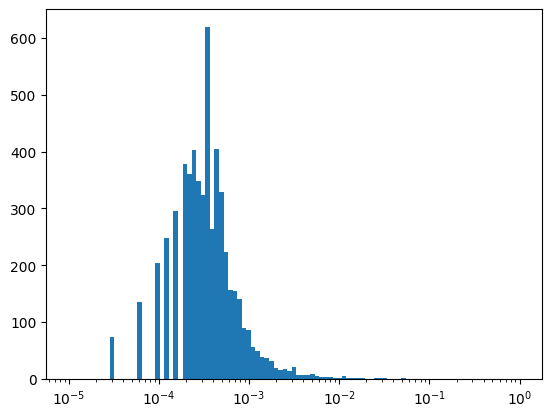

In [20]:
ae = AutoEncoder(activation_dim, dictionary_size).cuda()
ae.load_state_dict(
    t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{layer}/1_{dictionary_size}/ae.pt')
)

dict_acts = ae.encode(acts.cuda())
freqs = (dict_acts !=0).sum(dim=0) / dict_acts.shape[0]

plt.figure()
plt.hist(freqs.cpu(), bins=t.logspace(-5, 0, 100))
plt.xscale('log')

In [6]:
# make gif
for checkpoint in range(0, 101000, 5000):
    ae = AutoEncoder(activation_dim, dictionary_size).cuda()
    ae.load_state_dict(
        t.load(f'/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped/mlp_out_layer{layer}/1_{dictionary_size}/checkpoints/ae_{checkpoint}.pt')
    )

    dict_acts = ae.encode(acts.cuda())
    freqs = (dict_acts !=0).sum(dim=0) / dict_acts.shape[0]

    plt.figure()
    plt.hist(freqs.cpu(), bins=t.logspace(-5, 0, 100))
    plt.xscale('log')
    plt.title(f'Layer {layer} - checkpoint {checkpoint}, 1_32768')
    plt.savefig(f'junk/{checkpoint}_hist.png')
    plt.close()


In [7]:
images = [
    imageio.imread(f'junk/{checkpoint}_hist.png')
    for checkpoint in range(0, 103000, 5000)
]
imageio.mimsave('junk/hist.gif', images, fps=1)

/tmp/ipykernel_312287/522497389.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(f'junk/{checkpoint}_hist.png')


In [25]:
from einops import rearrange
import torch as t

inputs = buffer.tokenized_batch(batch_size=512)
with model.generate(max_new_tokens=1, pad_token_id=model.tokenizer.pad_token_id) as generator:
    with generator.invoke(inputs['input_ids'], scan=False) as invoker:
        hidden_states = submodule.output.save()
dictionary_activations = ae.encode(hidden_states.value)
flattened_acts = rearrange(dictionary_activations, 'b n d -> (b n) d')
freqs = (flattened_acts !=0).sum(dim=0) / flattened_acts.shape[0]

In [26]:
for idx, freq in enumerate(freqs):
    if 1e-2 < freq and freq < 3e-2:
        print(f"feat {idx} freq: {freq}")

feat 7525 freq: 0.011383056640625
feat 7809 freq: 0.0272674560546875
feat 8835 freq: 0.0139312744140625
feat 10634 freq: 0.011322021484375
feat 11587 freq: 0.012908935546875
feat 12830 freq: 0.0178680419921875
feat 21872 freq: 0.012542724609375
feat 25244 freq: 0.0259246826171875
feat 29207 freq: 0.01239013671875
feat 32717 freq: 0.0146942138671875


In [27]:
def list_decode(x):
    if isinstance(x, int):
        return model.tokenizer.decode(x)
    else:
        return [list_decode(y) for y in x]

In [30]:
k = 30
feat = 13920
acts = dictionary_activations[:, :, feat].cpu()
flattened_acts = rearrange(acts, 'b l -> (b l)')
topk_indices = t.argsort(flattened_acts, dim=0, descending=True)[:k]
batch_indices = topk_indices // acts.shape[1]
token_indices = topk_indices % acts.shape[1]

In [31]:
from circuitsvis.activations import text_neuron_activations

tokens = [
    inputs['input_ids'][batch_idx, :token_idx+1].tolist() for batch_idx, token_idx in zip(batch_indices, token_indices)
]
tokens = list_decode(tokens)
activations = [
    acts[batch_idx, :token_id+1, None, None] for batch_idx, token_id in zip(batch_indices, token_indices)
]
text_neuron_activations(tokens, activations)

In [18]:
batch_indices

tensor([40, 40, 40, 40, 40, 40, 40, 40, 15,  7,  7,  1, 15, 15, 15, 40, 15, 15,
        15,  7, 53, 53, 15, 15,  7, 15, 15, 46,  1, 15])

In [19]:
print(model.tokenizer.decode(inputs[40].ids))


972 P.2d 566 (1999)
CITY OF TACOMA, a municipal corporation, Appellant,
v.
FRANCISCAN FOUNDATION, aka St. Joseph Hospital And Healthcare Center, a Washington nonprofit corporation, Respondent.
No. 23107-7-II.
Court of Appeals of Washington, Division 2.
March 5, 1999.
*567 Jean P Homan, Assistant City Attorney, Tacoma, for Appellant.
Linda Gayle White Atkins, Davis Wright Tremaine, Bellevue, for Respondent.
HOUGHTON, J.



In [22]:
import numpy as np
import torch
k = 10
found_indices = torch.argsort(dictionary_activations, descending=True)[:k]
num_datapoints = int(dictionary_activations.shape[0]/128)
datapoint_indices =[np.unravel_index(i, (64, 128)) for i in found_indices]
text_list = []
full_text = []
token_list = []
full_token_list = []
for md, s_ind in datapoint_indices:
    md = int(md)
    s_ind = int(s_ind)
    full_tok = torch.tensor(dataset[md]["input_ids"])
    full_text.append(tokenizer.decode(full_tok))
    tok = dataset[md]["input_ids"][:s_ind+1]
    text = tokenizer.decode(tok)
    text_list.append(text)
    token_list.append(tok)
    full_token_list.append(full_tok)
text_list, full_text, token_list, full_token_list

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
import torch 
# num_features, d_model = autoencoder.encoder.shape # Fix this for shape purposes
texts = buffer.text_batch()
datapoints = len(texts)
batch_size = 64
neuron_activations = torch.zeros((datapoints*max_length, d_model))
dictionary_activations = torch.zeros((datapoints*max_length))

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        # Replace this with your residual stream stuff
        # _, cache = model.run_with_cache(batch.to(device))
        # batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )

        # Replace with your projection to probe direction
        # batched_dictionary_activations = smaller_auto_encoder.encode(batched_neuron_activations)
        dictionary_activations[i*batch_size*max_length:(i+1)*batch_size*max_length] = batched_dictionary_activations.cpu()

In [9]:
import torch as t
def entropy(p):
    p = p/p.sum(dim=-1, keepdim=True)
    log_p = p.log().nan_to_num()
    entropies = -(p * log_p).sum(dim=-1)
    out = entropies.nan_to_num().mean()
    return out

In [10]:
x = t.Tensor([[0, 0,0], [1, 4, 2]])
entropy(x)

tensor(0.4778)

In [11]:
x

tensor([[0., 0., 0.],
        [1., 4., 2.]])

In [12]:
x * x.log()

tensor([[   nan,    nan,    nan],
        [0.0000, 5.5452, 1.3863]])

In [6]:
0 * float("-inf")

nan

In [1]:
import torch as t

def entropy(p):
    eps = 1e-8
    # Calculate the sum along the last dimension (i.e., sum of each vector in the batch)
    p_sum = p.sum(dim=-1, keepdim=True)
    
    # Avoid in-place operations that can interfere with autograd
    p_normed = p / (p_sum + eps)  # Add eps to prevent division by zero
    
    # Compute the log safely, adding eps inside the log to prevent log(0)
    p_log = t.log(p_normed + eps)  # Add eps to prevent log(0)

    # Compute the entropy, this will give zero for elements where p_normed is zero
    ent = -(p_normed * p_log)
    
    # Zero out the entropy where the sum of p is zero (i.e., for all-zero vectors)
    ent = t.where(p_sum > 0, ent, t.zeros_like(ent))

    # Sum the entropy across the features and then take the mean across the batch
    return ent.sum(dim=-1).mean()

# Example usage:
batch_size = 3
vector_length = 5
p = t.tensor([[0.1, 0.2, 0.7, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0],  # All-zero vector
              [0.3, 0.3, 0.4, 0.0, 0.0]], requires_grad=True)

entropy_value = entropy(p)
entropy_value.backward()

print("Entropy:", entropy_value.item())
print("Gradients:", p.grad)

Entropy: 0.6302395462989807
Gradients: tensor([[ 0.5003,  0.2692, -0.1484,  6.2063,  6.2063],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0384,  0.0384, -0.0575,  6.1106,  6.1106]])
